# 2022-08-24 Finite Differences

## Last time
* Discussion and scoping
* Evaluating derivatives
* Taylor series and truncation error

## Today
* Discuss activity
* Measuring errors
* Stable discretizations
* 

In [3]:
using Plots
default(linewidth=3)
using LinearAlgebra

# Finite Difference/collocation approach to solve $u$:

\begin{gather} -\frac{d^2 u}{dx^2} = f(x) \quad x \in \Omega = (-1,1) \\
u(-1) = a \quad \frac{du}{dx}(1) = b .
\end{gather}

* Represent the function $u(x)$ by its values $u_i = u(x_i)$ at a discrete set of points $$ -1 = x_1 < x_2 < \dotsb < x_n = 1 . $$
  * The FD framework does not uniquely specify the solution values at other points
* Compute derivatives at $x_i$ via differencing formulas involving a finite number of neighbor points (independent of the total number of points $n$).
* FD methods ask for the differential equation to be satisfied pointwise at each $x_i$ in the interior of the domain.
* Evaluate the forcing term $f$ pointwise at $x_i$.
* Approximate derivatives at discrete boundary points ($x_n = 1$ above), typically using one-sided differencing formulas.

# Activity on stability and accuracy computing derivatives

# A note on stable computation

In [37]:
x = 1e-10
@show x
@show log(1 + x)

x = 1.0e-10
log(1 + x) = 1.000000082690371e-10


1.000000082690371e-10

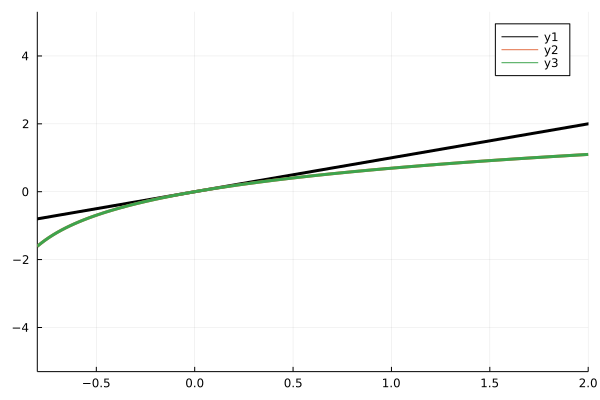

In [45]:
plot(x -> x, color=:black)
plot!([x -> log(1 + x), log1p], xlims=(-.8, 2))

What happens as we zoom in?

# A few methods on grids

In [6]:
diff1l(x, u) = x[2:end],   (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1r(x, u) = x[1:end-1], (u[2:end] - u[1:end-1]) ./ (x[2:end] - x[1:end-1])
diff1c(x, u) = x[2:end-1], (u[3:end] - u[1:end-2]) ./ (x[3:end] - x[1:end-2])
difflist = [diff1l, diff1r, diff1c]

n = 20
h = 2 / (n - 1)
x = LinRange(-3, 3, n)
u = sin.(x)
fig = plot(cos, xlims=(-3, 3))
for d in difflist
    xx, yy = d(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d)
end

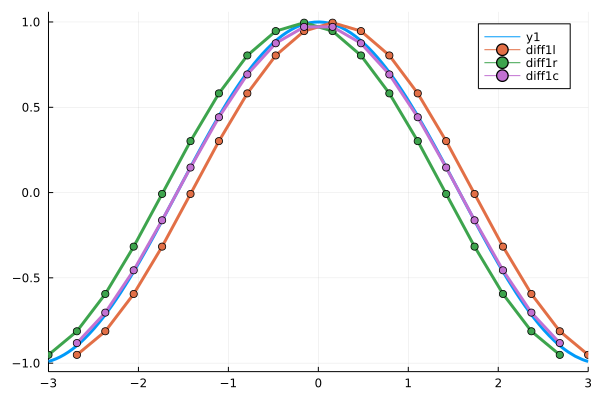

In [7]:
fig

# Measuring error on grids

In [33]:
using LinearAlgebra

grids = 2 .^ (2:10)
hs = 1 ./ grids
function refinement_error(f, fprime, d)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d(x, f.(x))
        push!(error, norm(yy - fprime.(xx), Inf))
    end
    error
end

refinement_error (generic function with 1 method)

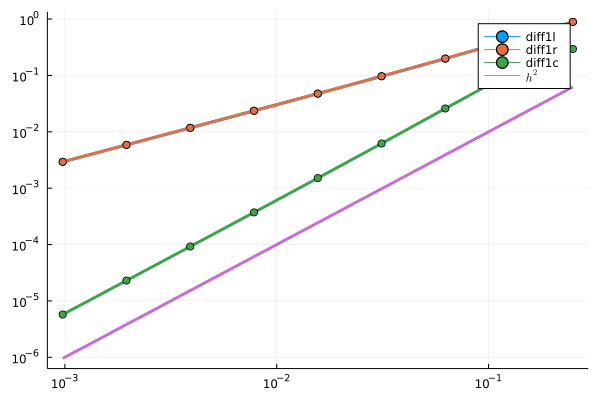

In [35]:
fig = plot(xscale=:log10, yscale=:log10)
for d in difflist
    error = refinement_error(sin, cos, d)
    plot!(fig, hs, error, marker=:circle, label=d)
end
plot!(fig, hs, hs .^ 2, label="\$h^2\$")

What happens if we use a 1-norm or 2-norm?

# Stability

Are there "rough" functions for which these formulas estimate $u'(x_i) = 0$?

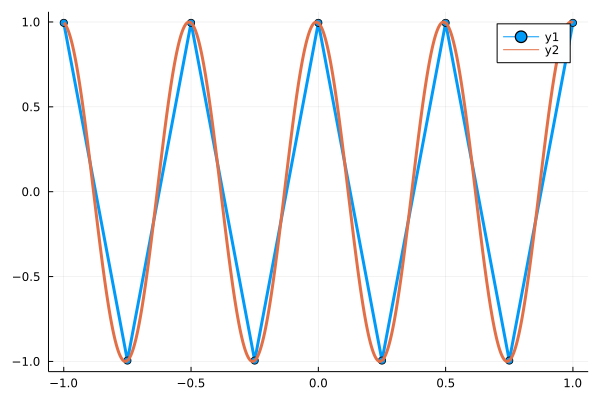

In [10]:
x = LinRange(-1, 1, 9)
f_rough(x) = cos(.1 + 4π*x)
fp_rough(x) = -4π*sin(.1 + 4π*x)

plot(x, f_rough, marker=:circle)
plot!(f_rough)

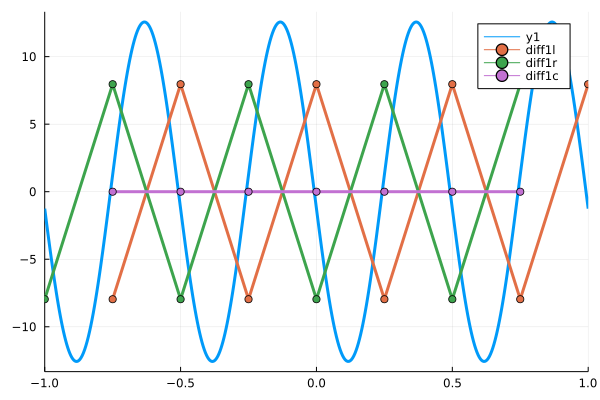

In [11]:
fig = plot(fp_rough, xlims=(-1, 1))
for d in difflist
    xx, yy = d(x, f_rough.(x))
    plot!(fig, xx, yy, label=d, marker=:circle)
end
fig

If we have a solution $u(x)$, then $u(x) + f_{\text{rough}}(x)$ is indistinguishable to our FD method.

# Consistency + Stability = Convergence

## Consistency

* When we apply the differential operator to the exact solution, we get a small residual.
* The residual converges under grid refinement.
* Hopefully fast as $h \to 0$

## Stability

* There do not exist "bad" functions that also satisfy the equation.
* This gets subtle for problems like incompressible flow.



# Second derivatives

We can compute a second derivative by applying first derivatives twice.

In [12]:
function diff2a(x, u)
    xx, yy = diff1c(x, u)
    diff1c(xx, yy)
end

function diff2b(x, u)
    xx, yy = diff1l(x, u)
    diff1r(xx, yy)
end

diff2list = [diff2a, diff2b]
n = 10
x = LinRange(-3, 3, n)
u = - cos.(x);

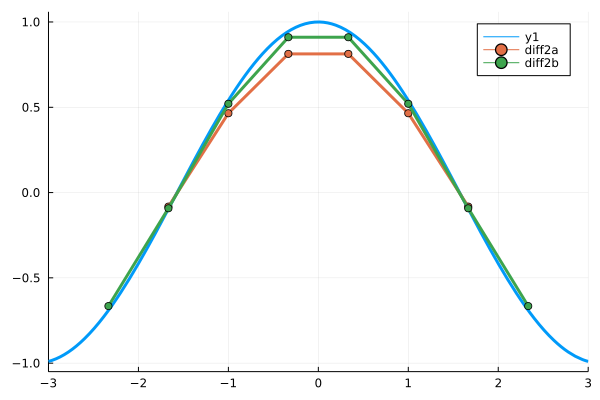

In [13]:
fig = plot(cos, xlims=(-3, 3))
for d2 in diff2list
    xx, yy = d2(x, u)
    plot!(fig, xx, yy, marker=:circle, label=d2)
end
fig

# How fast do these approximations converge?

In [14]:
grids = 2 .^ (3:10)
hs = 1 ./ grids
function refinement_error2(f, f_xx, d2)
    error = []
    for n in grids
        x = LinRange(-3, 3, n)
        xx, yy = d2(x, f.(x))
        push!(error, norm(yy - f_xx.(xx), Inf))
    end
    error
end

refinement_error2 (generic function with 1 method)

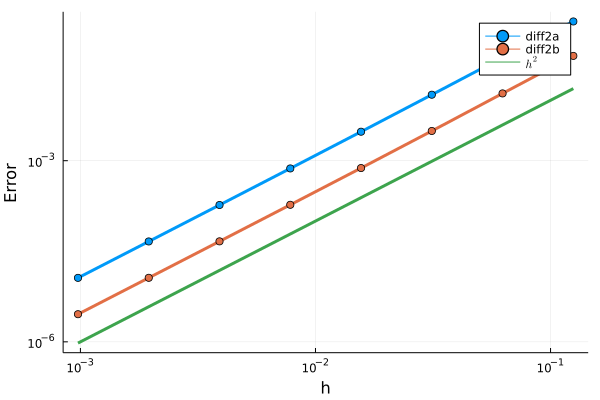

In [29]:
fig = plot(xlabel="h", xscale=:log10, ylabel="Error", yscale=:log10)
for d2 in diff2list
    error = refinement_error2(x -> -cos(x), cos, d2)
    plot!(fig, hs, error, marker=:circle, label=d2)
end
plot!(fig, hs, hs .^ 2, label="\$h^2\$") 

* Both methods are second order accurate.
* The `diff2b` method is more accurate than `diff2a` (by a factor of 4)
* The `diff2b` method can't compute derivatives at points adjacent the boundary.
* We don't know yet whether either is stable

# Differentiation matrices

All our `diff*` functions thus far have been linear in `u`, therefore they can be represented as matrices.
$$\frac{u_{i+1} - u_i}{x_{i+1} - x_i} = \begin{bmatrix} -1/h & 1/h \end{bmatrix} \begin{bmatrix} u_i \\ u_{i+1} \end{bmatrix}$$

In [52]:
function diff1_mat(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1:2] = [-1/h  1/h]
    for i in 2:n-1
        D[i, i-1:i+1] = [-1/2h  0  1/2h]
    end
    D[n, n-1:n] = [-1/h  1/h]
    D
end

diff1_mat (generic function with 1 method)

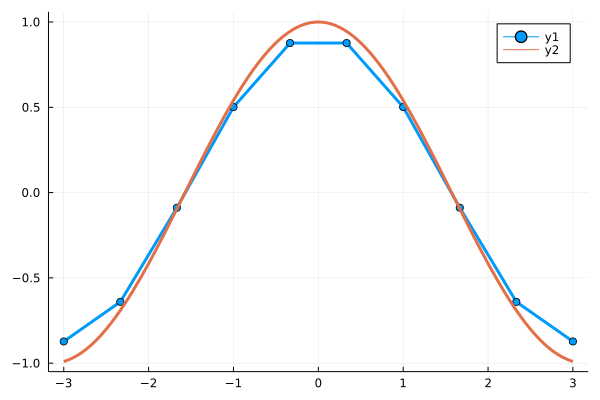

In [54]:
x = LinRange(-3, 3, 10)
plot(x, diff1_mat(x) * sin.(x), marker=:circle)
plot!(cos)

# How accurate is this derivative matrix?

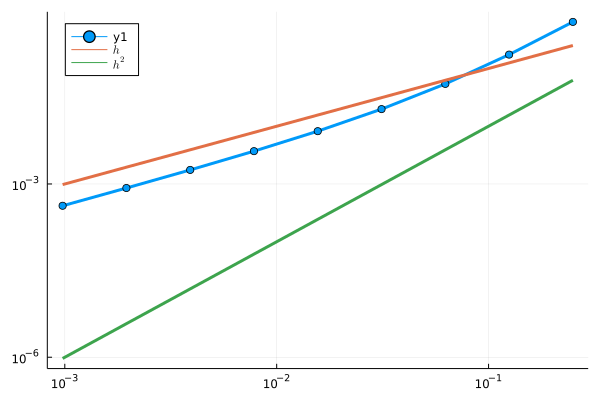

In [55]:
fig = plot(xscale=:log10, yscale=:log10, legend=:topleft)
error = refinement_error(sin, cos, (x, u) -> (x, diff1_mat(x) * u))
plot!(fig, hs, error, marker=:circle)
plot!(fig, hs, hs, label="\$h\$")
plot!(fig, hs, hs .^ 2, label="\$h^2\$")

# Can we study it as a matrix?

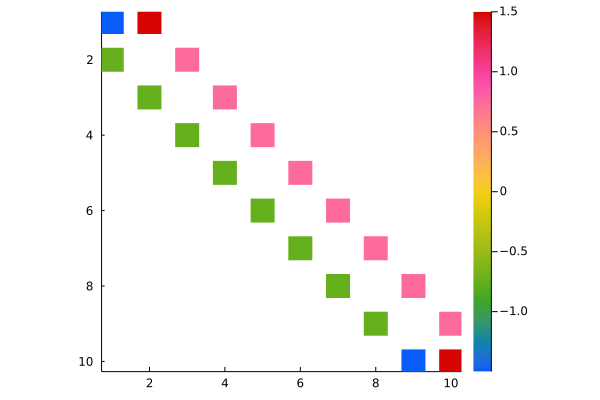

In [62]:
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

D = diff1_mat(x)
my_spy(D)

In [60]:
svdvals(D)

10-element Vector{Float64}:
 2.268133218393964
 2.2674392839412794
 1.4265847744427302
 1.368373796830966
 1.2135254915624205
 1.0228485194005286
 0.8816778784387096
 0.5437139466339259
 0.46352549156242107
 3.7873060138463766e-17

# Second derivative with Dirichlet boundary conditions

The left endpoint in our example boundary value problem has a Dirichlet boundary condition,
$$u(-1) = a . $$
With finite difference methods, we have an explicit degree of freedom $u_1 = u(x_1 = -1)$ at that endpoint.
When building a matrix system for the BVP, we can implement this boundary condition by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{2:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_1 \\ \\ u_{2:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{2:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.

In [21]:
function laplacian_dirichlet(x)
    n = length(x)
    D = zeros(n, n)
    h = x[2] - x[1]
    D[1, 1] = 1
    for i in 2:n-1
        D[i, i-1:i+1] = (1/h^2) * [-1, 2, -1]
    end
    D[n, n] = 1
    D
end

laplacian_dirichlet (generic function with 1 method)

# Laplacian as a matrix

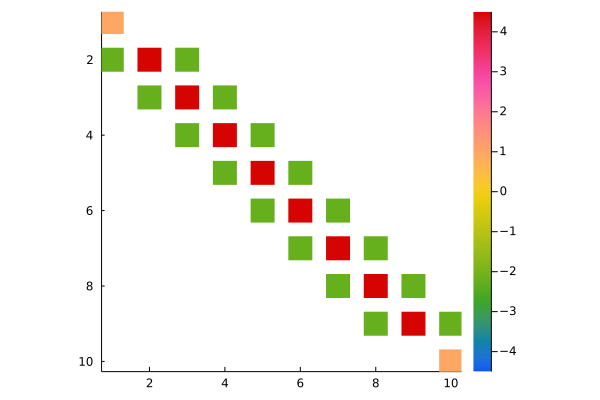

In [63]:
L = laplacian_dirichlet(x)
my_spy(L)

In [23]:
cond(L)

36.5545720479542

# Solutions

$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{2:n-1,:} & & \\ \\ \\ 0&0 &0 &0 &0 & 1 \end{bmatrix} \begin{bmatrix} u_1 \\ \\ u_{2:} \\ \\ \\ u_n \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{2:} \\ \\ \\ b \end{bmatrix} . $$

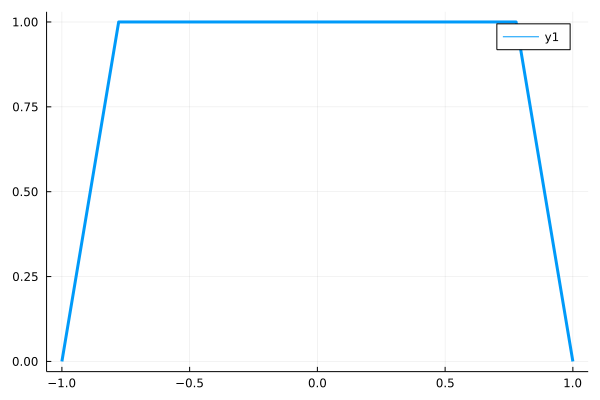

In [84]:
L = laplacian_dirichlet(x)
f = one.(x)
f[1] = 0
f[end] = 0;
plot(x, f)

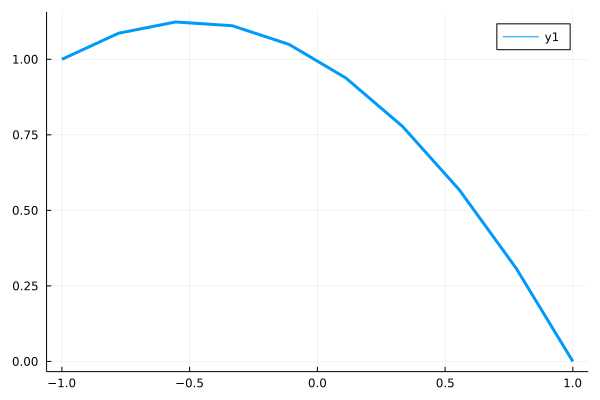

In [83]:
u = L \ f
plot(x, u)

# Discrete "Green's functions"

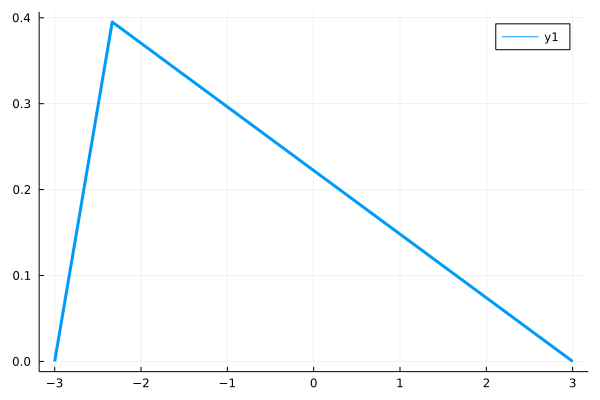

In [24]:
plot(x, inv(L)[:, 2])

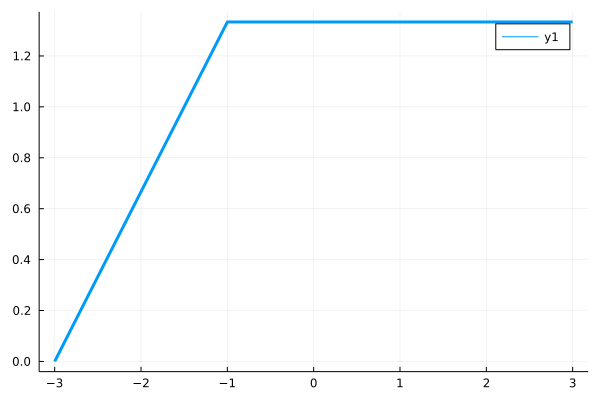

In [25]:
Ln = copy(L)
Ln[n, n-1] = -1
plot(x, inv(Ln)[:, 4])

# Discrete eigenfunctions

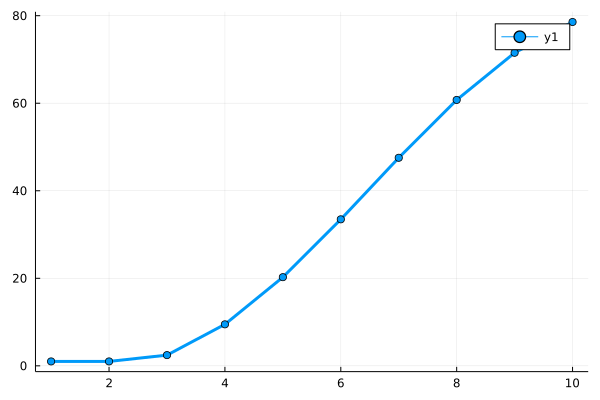

In [68]:
x = LinRange(-1, 1, 10)
L = laplacian_dirichlet(x)
Lambda, V = eigen(L)
plot(Lambda, marker=:circle)

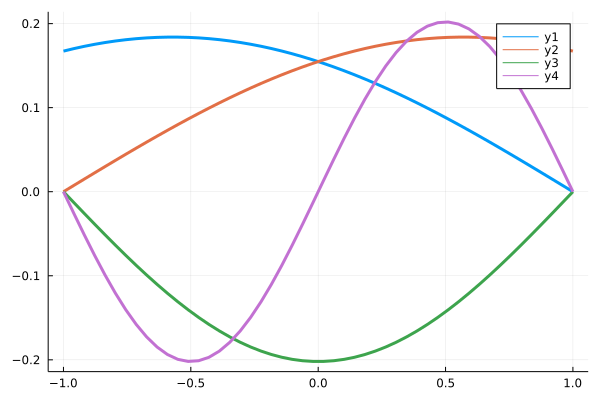

In [67]:
plot(x, V[:, 1:4])

# Outlook on our method

## Pros

* Consistent
* Stable
* Second order accurate (we hope)

## Cons

* Only second order accurate (at best)
* Worse than second order on non-uniform grids
* Worse than second order at Neumann boundaries
* Boundary conditions break symmetry